<a href="https://colab.research.google.com/github/Bookmaster9/image-classification/blob/master/dl_v2_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import itertools

# mount google drive for access to local files if necessary
drive.mount('/content/drive/')
!ls "/content/drive/My Drive"

# install kaggle and tuner package
!pip install -q kaggle

# install keras tuner package
!pip install -q -U keras-tuner
import kerastuner as kt

# generate the api token json file from kaggle account
# upload to drive and then copy
!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/app/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#!kaggle datasets list
# !kaggle datasets download -d andrewmvd/pediatric-pneumonia-chest-xray
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -qq chest-xray-pneumonia.zip
!rm chest-xray-pneumonia.zip
!rm -rf chest_xray/__MACOSX
!rm -rf chest_xray/chest_xray
!find . -print | grep -i '.*[.]jpeg' | wc -l

# datasets for normal, covid-19, pneumonia-viral and pneumonia-baterial; 
# curated more complete than Paul M set; only test normal and pneumonia-bacterial classes
!kaggle datasets download -d unaissait/curated-chest-xray-image-dataset-for-covid19
!unzip -qq curated-chest-xray-image-dataset-for-covid19.zip
!rm curated-chest-xray-image-dataset-for-covid19.zip
!rm -rf Curated\ X-Ray\ Dataset/COVID-19
!rm -rf Curated\ X-Ray\ Dataset/Pneumonia-Viral
!find . -print | grep -i '.*[.]jpg' | wc -l

Mounted at /content/drive/
 app						 rsi-app-v2.docx
 Application.gdoc				'Untitled document (1).gdoc'
'Colab Notebooks'				'Untitled document (2).gdoc'
'honor code.pdf'				'Untitled document (3).gdoc'
 Other						'Untitled document.gdoc'
'problems i need to redo before the test.gdoc'	'Untitled folder'
'Research proposal 2020.docx'			'Untitled presentation.gslides'
 rsi-app.docx					'Untitled spreadsheet.gsheet'
     |████████████████████████████████| 71kB 9.1MB/s 
100% 2.29G/2.29G [00:30<00:00, 18.3MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.1MB/s]
5860
100% 3.49G/3.49G [01:23<00:00, 28.8MB/s]

6280


In [ ]:
def preprocess_images(path, img_suffix):
  """ remove corrupted images and do basic exploratory analysis on datasets """
  num_skipped = 0
  img_shape = {}
  file_count = {}

  for root, dirs, files in os.walk(path, topdown = False):
    for dname in dirs:
        dpath = os.path.join(root, dname)
        n_file = 0
        for fname in os.listdir(dpath):
          fullpath = os.path.join(dpath, fname)
          if(fname.find(img_suffix) > 0):
            try:
                fobj = open(fullpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fullpath)
                continue
            else:
              n_file += 1

            img = cv2.imread(fullpath)
            img_shape[fname] = img.shape
        file_count[dpath] = n_file

  for k, v in file_count.items():
    print(k, ' --> ', v)

  # explor image shapes
  sumx = 0
  sumy = 0
  color = 0
  count = 0
  x = []
  y = []

  for k in img_shape:
    sumx += img_shape[k][0]
    sumy += img_shape[k][1]
    color += img_shape[k][2]
    x.append(img_shape[k][0])
    y.append(img_shape[k][1])
    count += 1

  avgx = round(sumx / count)
  avgy = round(sumy / count)
  avgc = round(color / count)

  print("number of currupted images removed = ", num_skipped)
  print('image shape: ', avgx, ' x ', avgy, ' x ', avgc)
  sns.regplot(x=x, y=y, line_kws={'lw': 2, 'color': 'red'})

In [ ]:
def move_files(source, destination):
  """ Move files between directories """
  for i in os.listdir(source):
      if not os.path.exists(destination):
          shutil.move(os.path.join(source, i), destination)
      else:
          shutil.copy2(os.path.join(source, i), destination)

In [ ]:
def explore_images(path):
  """ explore some images before and after augmentation """
  IMAGE_SIZE = (128, 128)
  SEED = 1337

  train_ds = tf.keras.preprocessing.image_dataset_from_directory(path, validation_split=0.2, subset='training', image_size=IMAGE_SIZE, seed=SEED)
  class_names = train_ds.class_names

  # original images
  plt.figure(figsize=(20, 8))
  for images, labels in train_ds.take(1):
    for i in range(10):
      ax = plt.subplot(2, 5, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      # plt.title(int(labels[i]))
      plt.axis("off")

  # data augmentation - flip and rotate some images 
  data_augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
      ]
  )

  # images after augmentations
  plt.figure(figsize=(20, 8))
  for images, labels in train_ds.take(1):
      for i in range(10):
          augmented_images = data_augmentation(images)
          ax = plt.subplot(2, 5, i + 1)
          plt.imshow(augmented_images[0].numpy().astype("uint8"))
          plt.title(class_names[int(labels[i])])
          plt.axis("off")
  plt.show()

In [ ]:
def build_base_model(image_size, num_classes, learning_rate):
  """ Build the base CNN model """

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=image_size + (3,)))
  model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

  model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

  model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

  model.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(units=128,activation='relu'))
  model.add(tf.keras.layers.Dense(units=64,activation='relu'))

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  model.add(tf.keras.layers.Dense(units,activation=activation))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )
  return model

In [ ]:
def build_augmented_model(image_size, num_classes, learning_rate):
  """ Build the augmented model (base model with augmentation) """

  data_augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
      ]
  )

  inputs = tf.keras.Input(shape = image_size + (3,))
  model = data_augmentation(inputs)

  model = tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu')(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu')(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu')(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu')(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Flatten()(model)

  model = tf.keras.layers.Dense(units=128,activation='relu')(model)
  model = tf.keras.layers.Dense(units=64,activation='relu')(model)

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  outputs = tf.keras.layers.Dense(units, activation=activation)(model)
  
  model = tf.keras.Model(inputs, outputs)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )

  return model

In [ ]:
def build_tunable_model(hp):
  """ Build model to tune hyperparameters """

  image_size = (128, 128)
  input_shape = image_size + (3,)
  inputs = tf.keras.Input(shape=input_shape)
  data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
  )
  x = data_augmentation(inputs)

  for i in range(hp.Int('conv_blocks', 3, 5, default = 3)):
    filters = hp.Int('flters_' + str(i), 32, 256, step=32)
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, activation='relu', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(x)

  x = tf.keras.layers.Flatten()(x)

  for j in range(hp.Int('dense_blocks', 1, 2, default = 2)):
    dense_layers = hp.Int('dense_' + str(j), 32, 128, step=32, default=64)
    x = tf.keras.layers.Dense(dense_layers, activation='relu')(x)
    x = tf.keras.layers.Dropout(
        hp.Float('dropout', 0.0, 0.5, step=0.1, default = 0.2))(x)

  outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

  model = tf.keras.Model(inputs, outputs)

  model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Choice('learning_rate', values = [1e-6, 1e-5, 1e-4])),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  return model


In [ ]:
def tune_model(train_ds, val_ds, class_weights):
  """ Tuned model with keras tuner """
  tuner = kt.Hyperband(
      build_tunable_model,
      objective='val_accuracy',
      max_epochs=10,
      hyperband_iterations=2,
      overwrite=True)

  tuner.search(train_ds,
              validation_data=val_ds,
              class_weight = class_weights,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

  best_model = tuner.get_best_models(1)[0]

  return best_model

In [ ]:
def build_tuned_model(image_size, num_classes, learning_rate):
  """ Build optimized model with tuned hyperparameters """

  data_augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
      ]
  )

  inputs = tf.keras.Input(shape = image_size + (3,))
  model = data_augmentation(inputs)

  model = tf.keras.layers.Conv2D(filters=160,kernel_size=3,activation='relu', padding = 'same')(model)
  model = tf.keras.layers.BatchNormalization()(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding = 'same')(model)
  model = tf.keras.layers.BatchNormalization()(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=192,kernel_size=3,activation='relu',padding = 'same')(model)
  model = tf.keras.layers.BatchNormalization()(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=160,kernel_size=3,activation='relu',padding = 'same')(model)
  model = tf.keras.layers.BatchNormalization()(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Flatten()(model)

  model = tf.keras.layers.Dense(units=96,activation='relu')(model)
  model = tf.keras.layers.Dropout(0.3)(model)

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  outputs = tf.keras.layers.Dense(units, activation=activation)(model)
  
  model = tf.keras.Model(inputs, outputs)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )

  return model

In [ ]:
def train_base_model(model, train_ds, val_ds, epochs, save_model_fname):
  """ Train the base model """

  callbacks = [
      tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
  ]

  history = model.fit(
      train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
  )

  model.save(save_model_fname)

  return history

In [ ]:
def train_weighted_model(model, train_ds, val_ds, epochs, save_model_fname, class_weights):
  """ Train the model with custom class weights """

  callbacks = [
      tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
  ]

  history = model.fit(
      train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, class_weight=class_weights
  )

  model.save(save_model_fname)

  return history

In [ ]:
def plot_accuracy(history):
  """ Plot model accuracy by epochs """
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy vs. No. of epochs')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')
  plt.show()  

In [ ]:
def plot_loss(history):
  """ Plot Model loss by epochs """
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss vs. No of epochs')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

In [ ]:
def predict_image(model_path, image_path, image_size=(128, 128)):
  """ Predict classification of single image from trained model  """
  CATEGORIES = ['Normal', 'Pneumonia']

  img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  loaded_model = tf.keras.models.load_model(model_path)
  predictions = loaded_model.predict(img_array)
  score = predictions[0]

  print(
      "This image is %.2f percent NORMAL and %.2f percent PNEUMONIA."
      % (100 * (1-score), 100 * score)
  )

  return CATEGORIES[(predictions[0][0] > 0.5).astype("int32")]

In [ ]:
def predict_batch(model_path, folder_path, predict_class, image_size=(128, 128)):
  """ Predict classification of images from directory """
  
  # load the trained model
  model = tf.keras.models.load_model(model_path)

  images = []
  num_images = 0

  for img in os.listdir(folder_path):
    num_images += 1
    img = os.path.join(folder_path, img)
    img = tf.keras.preprocessing.image.load_img(img, target_size=image_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

  images = np.vstack(images)
  predictions = model.predict(images, batch_size=10)
  classes = (predictions[:,0] > 0.5).astype("int32")

  num_correct = int(sum(classes))
  
  if(predict_class == 0):
    num_correct = num_images - num_correct

  print("number of images in the path = ", num_images)
  print("number of images classified correctly = ", num_correct)
  print("classification accuracy = %.2f percent" % round(100 * (num_correct/num_images), 2))

  return round(100 * (num_correct/num_images), 2)


In [ ]:
def get_confusion_matrix(model_path, test_data_path, image_size=(128, 128)):
  """ Generate the confusion matrix using directory of test images"""
  model = tf.keras.models.load_model(model_path)
  
  test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
  test_data_generator = test_generator.flow_from_directory(
      test_data_path,
      target_size=image_size,
      batch_size=2,
      shuffle=False)
  test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

  predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch, verbose=1, workers=0)

  predicted_classes = np.where(predictions>0.5, 1, 0)

  true_classes = test_data_generator.classes

  class_labels = list(test_data_generator.class_indices.keys())

  report = sm.classification_report(true_classes, predicted_classes, target_names=class_labels)
  print(report)

  cm = sm.confusion_matrix(true_classes, predicted_classes)

  return cm

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='YlGnBu'):
  """ Generate the plot given a confusion matrix"""

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize: # normalized cm
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  
  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
          horizontalalignment="center",
          color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True class label')
  plt.xlabel('Predicted class label')
  plt.show()

In [ ]:
def plot_cm(pred_matrix, classes):
  fig, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(pred_matrix, linewidth=0.5, square=True,  cmap="YlGnBu", ax=ax, xticklabels=classes, yticklabels=classes)
  plt.show()

In [ ]:
def plot_roc(model_path, test_data_path, image_size=(128, 128)):
  """ Generate and plot ROC curve of model with test directory """

  model = tf.keras.models.load_model(model_path)
  
  test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
  test_data_generator = test_generator.flow_from_directory(
      test_data_path,
      target_size=image_size,
      batch_size=2,
      shuffle=False)
  test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

  predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch, verbose=1, workers=0)

  # predicted_classes = np.where(predictions>0.5, 1, 0)
  # class_labels = list(test_data_generator.class_indices.keys())

  true_classes = test_data_generator.classes

  fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, predictions)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.plot(fpr_keras, tpr_keras, color='darkorange', label='ROC curve (area = %0.2f)' % auc_keras)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")
  plt.show()


./chest_xray/train/NORMAL  -->  1300
./chest_xray/train/PNEUMONIA  -->  3743
./chest_xray/val/NORMAL  -->  2
./chest_xray/val/PNEUMONIA  -->  8
./chest_xray/test/NORMAL  -->  234
./chest_xray/test/PNEUMONIA  -->  352
./chest_xray/train  -->  0
./chest_xray/val  -->  0
./chest_xray/test  -->  0
number of currupted images removed =  217
image shape:  967  x  1325  x  3
Found 5053 files belonging to 2 classes.
Using 4043 files for training.


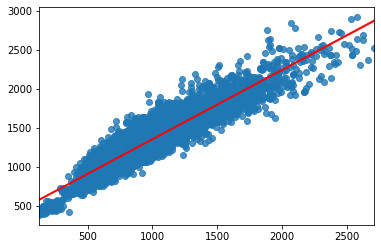

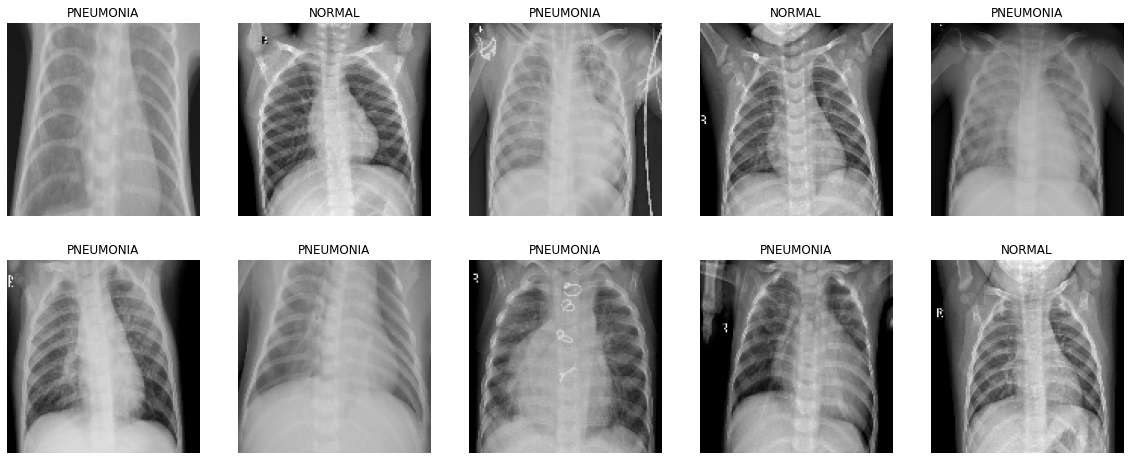

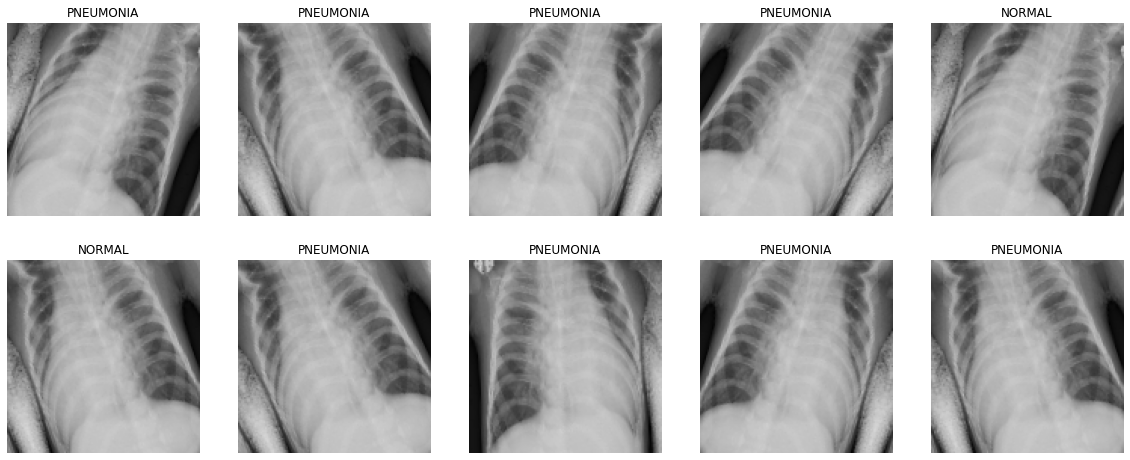

Found 5053 files belonging to 2 classes.
Using 4043 files for training.
Found 5053 files belonging to 2 classes.
Using 1010 files for validation.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)

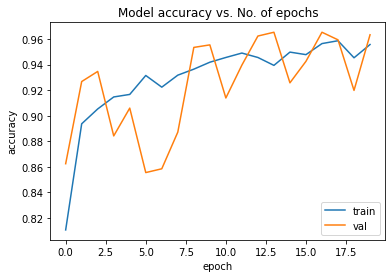

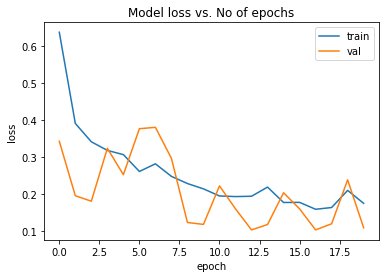

..... evaluating chest_xray dataset ...
This image is 96.98 percent NORMAL and 3.02 percent PNEUMONIA.
number of images in the path =  234
number of images classified correctly =  150
classification accuracy = 64.10 percent
number of images in the path =  352
number of images classified correctly =  342
classification accuracy = 97.16 percent
Found 586 images belonging to 2 classes.
  1/293 [..............................] - ETA: 30s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


293/293 [==============================] - 5s 18ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.64      0.76       234
   PNEUMONIA       0.80      0.97      0.88       352

    accuracy                           0.84       586
   macro avg       0.87      0.81      0.82       586
weighted avg       0.86      0.84      0.83       586



UnboundLocalError: ignored

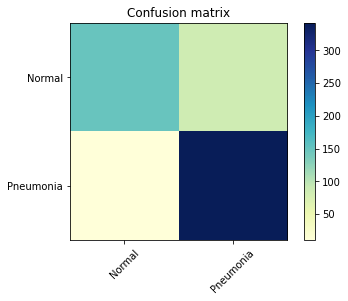

In [ ]:
# image file clean up
preprocess_images('./chest_xray', '.jpeg')

# combine files from validation dir to training dir
move_files('chest_xray/val/NORMAL', 'chest_xray/train/NORMAL')
move_files('chest_xray/val/PNEUMONIA', 'chest_xray/train/PNEUMONIA')

# explore some image files
explore_images('chest_xray/train')

# build a model
image_size = (128, 128)
batch_size = 32
num_classes = 2
learning_rate = 1e-5
seed = 1337
vsplit = 0.2
epochs = 20
save_model_fname = 'drive/My Drive/app/xray/xray-model-augmented-def.h5'
class_weights = {0: 2.88, 1: 1.00}

train_ds = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/train', validation_split=vsplit, subset='training', image_size=image_size, seed=seed)
val_ds = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/train', validation_split=vsplit, subset='validation', image_size=image_size, seed=seed)
train_ds = train_ds.prefetch(buffer_size = batch_size)
val_ds = val_ds.prefetch(buffer_size = batch_size)

# model = build_base_model(image_size=image_size, num_classes = num_classes, learning_rate = learning_rate)
model = build_augmented_model(image_size=image_size, num_classes = num_classes, learning_rate = learning_rate)
# model = tune_model(train_ds, val_ds, class_weights)
# model = build_tuned_model(image_size=image_size, num_classes = num_classes, learning_rate = learning_rate)

print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

# train the model
# history = train_base_model(model,train_ds, val_ds, epochs, save_model_fname)
# epochs = 10 # use less epochs for tuned model
history = train_weighted_model(model,train_ds, val_ds, epochs, save_model_fname, class_weights)

# evaluate the trained model 
plot_accuracy(history)
plot_loss(history)

##### chest xray dataset #####
# predict on individual images
print("..... evaluating chest_xray dataset ...")
image_path = "chest_xray/test/NORMAL/IM-0001-0001.jpeg"
predict_image(save_model_fname, image_path)

# predict on a batch of images for a class 
folder_path = 'chest_xray/test/NORMAL'
predict_class = 0 # normal
predict_batch(save_model_fname, folder_path, predict_class)

folder_path = 'chest_xray/test/PNEUMONIA'
predict_class = 1 # pneumonia
predict_batch(save_model_fname, folder_path, predict_class)

# plot confusion matrix for a test dataset in two classes
test_data_path = "chest_xray/test"
classes = ['Normal', 'Pneumonia']
cm = get_confusion_matrix(save_model_fname, test_data_path)
plot_confusion_matrix(cm, classes)

# plot ROC curve for a test dataset
test_data_path = "chest_xray/test"
plot_roc(save_model_fname, test_data_path)

##### covid-19 super dataset #####
# predict on individual images
print("..... evaluating covid-19 dataset ...")
image_path = 'Curated X-Ray Dataset/Normal/Normal (1008).jpg'
predict_image(save_model_fname, image_path)

image_path = 'Curated X-Ray Dataset/Pneumonia-Bacterial/Pneumonia-Bacterial (1008).jpg'
predict_image(save_model_fname, image_path)

# predict on a batch of images for a class 
folder_path = 'Curated X-Ray Dataset/Normal'
predict_class = 0 # normal
predict_batch(save_model_fname, folder_path, predict_class)

folder_path = 'Curated X-Ray Dataset/Pneumonia-Bacterial'
predict_class = 1 # pneumonia
predict_batch(save_model_fname, folder_path, predict_class)

# plot confusion matrix for a test dataset in two classes
test_data_path = "Curated X-Ray Dataset"
classes = ['Normal', 'Pneumonia']
cm = get_confusion_matrix(save_model_fname, test_data_path)
plot_confusion_matrix(cm, classes)

# plot ROC curve for a test dataset
test_data_path = "Curated X-Ray Dataset"
plot_roc(save_model_fname, test_data_path)

Found 586 images belonging to 2 classes.
  1/293 [..............................] - ETA: 30s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


293/293 [==============================] - 5s 18ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.64      0.76       234
   PNEUMONIA       0.80      0.97      0.88       352

    accuracy                           0.84       586
   macro avg       0.87      0.81      0.82       586
weighted avg       0.86      0.84      0.83       586



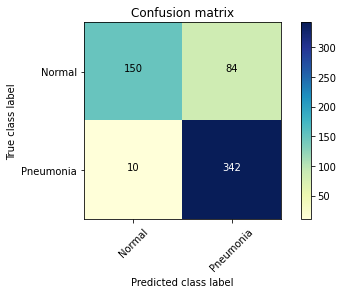

Found 586 images belonging to 2 classes.
293/293 [==============================] - 5s 18ms/step


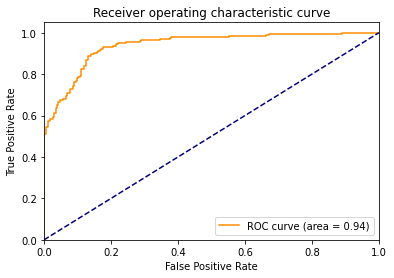

..... evaluating covid-19 dataset ...
This image is 99.81 percent NORMAL and 0.19 percent PNEUMONIA.
This image is 0.00 percent NORMAL and 100.00 percent PNEUMONIA.
number of images in the path =  3270
number of images classified correctly =  3068
classification accuracy = 93.82 percent
number of images in the path =  3001
number of images classified correctly =  2909
classification accuracy = 96.93 percent
Found 6271 images belonging to 2 classes.
   1/3136 [..............................] - ETA: 3:58

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3136/3136 [==============================] - 128s 41ms/step
                     precision    recall  f1-score   support

             Normal       0.97      0.94      0.95      3270
Pneumonia-Bacterial       0.94      0.97      0.95      3001

           accuracy                           0.95      6271
          macro avg       0.95      0.95      0.95      6271
       weighted avg       0.95      0.95      0.95      6271



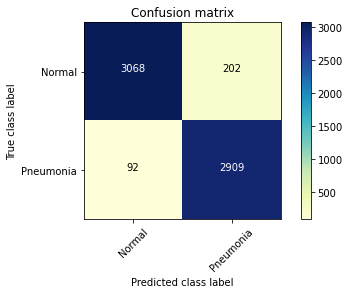

Found 6271 images belonging to 2 classes.
3136/3136 [==============================] - 128s 41ms/step


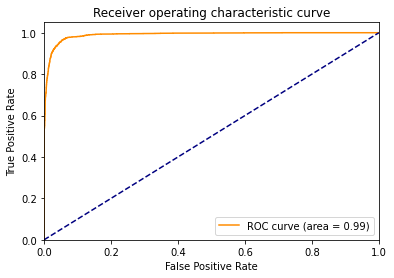

In [ ]:
# plot confusion matrix for a test dataset in two classes
test_data_path = "chest_xray/test"
classes = ['Normal', 'Pneumonia']
cm = get_confusion_matrix(save_model_fname, test_data_path)
plot_confusion_matrix(cm, classes)

# plot ROC curve for a test dataset
test_data_path = "chest_xray/test"
plot_roc(save_model_fname, test_data_path)

##### covid-19 super dataset #####
# predict on individual images
print("..... evaluating covid-19 dataset ...")
image_path = 'Curated X-Ray Dataset/Normal/Normal (1008).jpg'
predict_image(save_model_fname, image_path)

image_path = 'Curated X-Ray Dataset/Pneumonia-Bacterial/Pneumonia-Bacterial (1008).jpg'
predict_image(save_model_fname, image_path)

# predict on a batch of images for a class 
folder_path = 'Curated X-Ray Dataset/Normal'
predict_class = 0 # normal
predict_batch(save_model_fname, folder_path, predict_class)

folder_path = 'Curated X-Ray Dataset/Pneumonia-Bacterial'
predict_class = 1 # pneumonia
predict_batch(save_model_fname, folder_path, predict_class)

# plot confusion matrix for a test dataset in two classes
test_data_path = "Curated X-Ray Dataset"
classes = ['Normal', 'Pneumonia']
cm = get_confusion_matrix(save_model_fname, test_data_path)
plot_confusion_matrix(cm, classes)

# plot ROC curve for a test dataset
test_data_path = "Curated X-Ray Dataset"
plot_roc(save_model_fname, test_data_path)